 # Using prajjwal1/bert-tiny

In [2]:
!jupyter nbconvert --to html Untitled1.ipynb


[NbConvertApp] Converting notebook Untitled1.ipynb to html
Traceback (most recent call last):
  File "C:\Users\suhas\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "C:\Users\suhas\anaconda3\Lib\site-packages\jupyter_core\application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "C:\Users\suhas\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\suhas\anaconda3\Lib\site-packages\nbconvert\nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "C:\Users\suhas\anaconda3\Lib\site-packages\nbconvert\nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "C:\Users\suhas\anaconda3\Lib\site-packages\nbconvert\nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_single_notebook(
                        ^

In [3]:
from transformers import (AutoTokenizer,AutoModelForTokenClassification,Trainer,TrainingArguments,DataCollatorForTokenClassification)
from datasets import load_dataset
from seqeval.metrics import classification_report as seqeval_classification_report
import numpy as np

In [4]:
model_name = "prajjwal1/bert-tiny"

In [5]:
btc = load_dataset("tner/btc")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.86k [00:00<?, ?B/s]

btc.py:   0%|          | 0.00/3.91k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/494k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/77.7k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/180k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6338 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1001 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
# Extracting label names and mapping them to IDs
features = btc["train"].features["tags"]
label_list = features.feature.names
label_to_id = {l: i for i, l in enumerate(label_list)}
id_to_label = {i: l for i, l in enumerate(label_list)}


In [7]:
# Initializing the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    word_ids = tokenized_inputs.word_ids()
    label_ids = []
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:
            label_ids.append(example["tags"][word_idx])
        else:
            label_ids.append(-100)
        previous_word_idx = word_idx
    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs


In [9]:
# Applying tokenization to the entire dataset
btc_tokenized = btc.map(tokenize_and_align_labels)


Map:   0%|          | 0/6338 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
# Setting up a data collator to handle dynamic padding during batching
data_collator = DataCollatorForTokenClassification(tokenizer)


In [12]:
# Defining training arguments for controlling the training process
args = TrainingArguments(
    output_dir="ner_model_tiny",
    do_train=True,
    do_eval=True,
    logging_dir="./logs",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=10,
    save_steps=500,
    eval_steps=500,
    report_to=[],
    save_total_limit=2,
    disable_tqdm=False)


In [13]:
# Defining a function for computing evaluation metrics using seqeval
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)
    true_labels = [[id_to_label[l] for l in label if l != -100] for label in labels]
    true_preds = [[id_to_label[p] for (p, l) in zip(pred, label) if l != -100] for pred, label in zip(predictions, labels)]
    report = seqeval_classification_report(true_labels, true_preds, output_dict=True)
    return {"precision": report["weighted avg"]["precision"],"recall": report["weighted avg"]["recall"],"f1": report["weighted avg"]["f1-score"]}


In [14]:
# Setting up the Trainer for training and evaluation
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=btc_tokenized["train"],
    eval_dataset=btc_tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics)

<ipython-input-14-18a473a1605a>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
# Running training
trainer.train()

Step,Training Loss
10,1.773800
20,1.433800
30,1.162800
40,0.938300
50,0.822400
60,0.705000
70,0.668700
80,0.626700
90,0.602000
100,0.626500


TrainOutput(global_step=1191, training_loss=0.36845796027296635, metrics={'train_runtime': 22.4347, 'train_samples_per_second': 847.526, 'train_steps_per_second': 53.087, 'total_flos': 2354147230080.0, 'train_loss': 0.36845796027296635, 'epoch': 3.0})

In [16]:
# Evaluating the final model
trainer.evaluate()


{'eval_loss': 0.24161025881767273,
 'eval_precision': 0.6577252807427312,
 'eval_recall': 0.5780346820809249,
 'eval_f1': 0.5767579608940107,
 'eval_runtime': 0.8103,
 'eval_samples_per_second': 1235.349,
 'eval_steps_per_second': 77.749,
 'epoch': 3.0}

In [17]:
# Evaluating on the test set
test_results = trainer.evaluate(eval_dataset=btc_tokenized["test"])
print("Test Set Results:", test_results)


Test Set Results: {'eval_loss': 0.2476014941930771, 'eval_precision': 0.674673149492727, 'eval_recall': 0.5742687385740403, 'eval_f1': 0.5830648848827215, 'eval_runtime': 2.9615, 'eval_samples_per_second': 675.341, 'eval_steps_per_second': 42.209, 'epoch': 3.0}


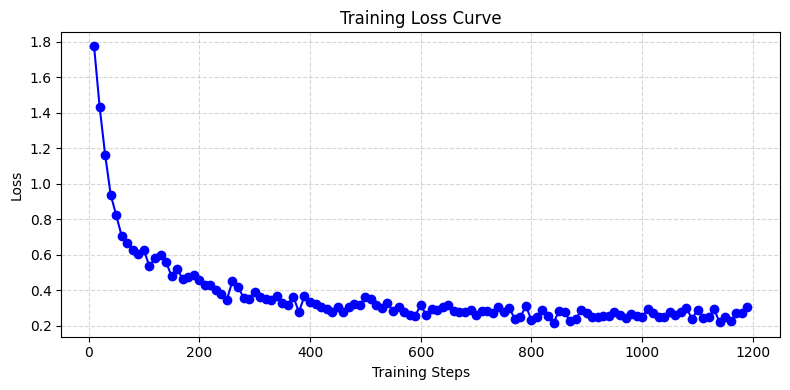

In [18]:
import matplotlib.pyplot as plt
loss_logs = [log for log in trainer.state.log_history if "loss" in log]
steps = [log["step"] for log in loss_logs]
losses = [log["loss"] for log in loss_logs]
plt.figure(figsize=(8, 4))
plt.plot(steps, losses, marker="o", linestyle="-", color="blue")
plt.title("Training Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Using distilbert-base-uncased

In [19]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=btc_tokenized["train"],
    eval_dataset=btc_tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-20-5bd0928dffe0>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
trainer.train()


Step,Training Loss
10,0.914600
20,0.391400
30,0.301000
40,0.264900
50,0.249500
60,0.223200
70,0.199700
80,0.195800
90,0.196200
100,0.189000


TrainOutput(global_step=1191, training_loss=0.10752862465969036, metrics={'train_runtime': 117.7961, 'train_samples_per_second': 161.414, 'train_steps_per_second': 10.111, 'total_flos': 251774952063360.0, 'train_loss': 0.10752862465969036, 'epoch': 3.0})

In [22]:
trainer.evaluate()

{'eval_loss': 0.18347814679145813,
 'eval_precision': 0.7733034025740173,
 'eval_recall': 0.7213872832369942,
 'eval_f1': 0.743009247335747,
 'eval_runtime': 1.9405,
 'eval_samples_per_second': 515.842,
 'eval_steps_per_second': 32.466,
 'epoch': 3.0}

In [23]:
test_results = trainer.evaluate(eval_dataset=btc_tokenized["test"])
print("Test Set Results:", test_results)

Test Set Results: {'eval_loss': 0.15531839430332184, 'eval_precision': 0.8038289252865073, 'eval_recall': 0.7442870201096892, 'eval_f1': 0.772491307182071, 'eval_runtime': 4.2158, 'eval_samples_per_second': 474.411, 'eval_steps_per_second': 29.651, 'epoch': 3.0}


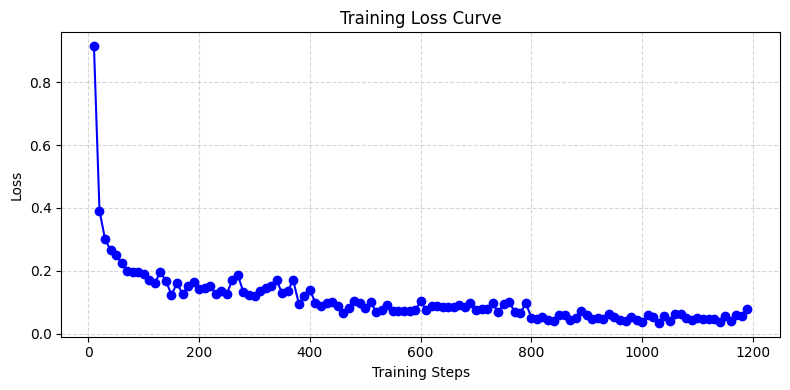

In [24]:
import matplotlib.pyplot as plt
loss_logs = [log for log in trainer.state.log_history if "loss" in log]
steps = [log["step"] for log in loss_logs]
losses = [log["loss"] for log in loss_logs]
plt.figure(figsize=(8, 4))
plt.plot(steps, losses, marker="o", linestyle="-", color="blue")
plt.title("Training Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [28]:
for i in range(len(btc["train"])):
    words = btc["train"][i]["tokens"]
    tags = btc["train"][i]["tags"]
    names = [id_to_label[t] for t in tags]
    found = False
    for name in names:
        if name != "O":
            found = True
            break
    if found:
        print("Example:", i)
        print("Word               Tag")
        print("-----------------------")
        for j in range(len(words)):
            print(f"{words[j]:<18}{names[j]}")
        break


Example: 4
Word               Tag
-----------------------
Think             O
you               O
call              O
that              O
smash             O
and               O
grab              O
.                 O
#                 O
Gateshead         B-LOC
's                O
media             O
man               O
just              O
admitted          O
to                O
me                O
it                O
was               O
'"'               O
daylight          O
robbery           O
'"'               O
.                 O
Shaw              B-PER
's                O
only              O
touch             O
was               O
his               O
goal              O
.                 O


In [31]:
from transformers import pipeline
outputs = trainer.predict(btc_tokenized["validation"])
preds = np.argmax(outputs.predictions, axis=-1)
labels = outputs.label_ids
def getWrong(data, preds, labels, count=5):
    wrong = []
    for i in range(len(data)):
        words = data[i]["tokens"]
        true = labels[i]
        pred = preds[i]
        trueTags = [id_to_label[t] for t in true if t != -100]
        predTags = [id_to_label[p] for p, t in zip(pred, true) if t != -100]
        if trueTags != predTags:
            wrong.append((words, trueTags, predTags))
        if len(wrong) >= count:
            break
    return wrong
wrongList = getWrong(btc["validation"], preds, labels)
for num, (words, true, pred) in enumerate(wrongList):
    print(f"--- Example {num+1} ---")
    print("Token           True Tag     Predicted Tag")
    print("---------------------------------------------")
    for w, t, p in zip(words, true, pred):
        print(f"{w:<16}{t:<13}{p}")
    print()


--- Example 1 ---
Token           True Tag     Predicted Tag
---------------------------------------------
I               O            O
posted          O            O
a               O            O
new             O            O
photo           O            O
to              O            O
Facebook        O            B-ORG
http://t.co/r98D54lZm0O            O

--- Example 2 ---
Token           True Tag     Predicted Tag
---------------------------------------------
Bom             O            B-PER
Dia             O            I-PER
:)              O            O

--- Example 3 ---
Token           True Tag     Predicted Tag
---------------------------------------------
RT              O            O
@               B-ORG        O
9GAGTweets      B-ORG        B-PER
:               O            O
Tried           O            O
to              O            O
take            O            O
a               O            O
selfie          O            O
with            O            O
my  

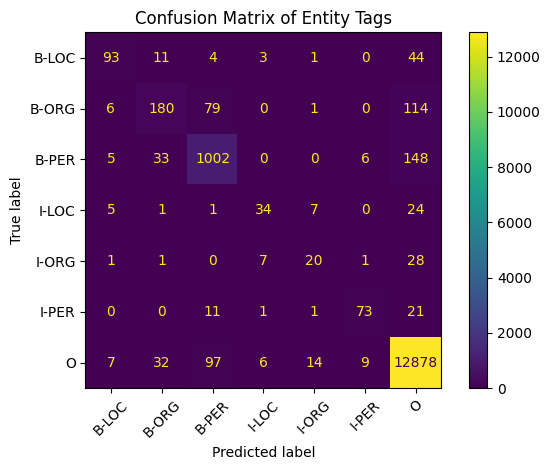

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
flat_true = [id_to_label[l] for label in labels for l in label if l != -100]
flat_pred = [id_to_label[p] for pred, label in zip(preds, labels) for p, l in zip(pred, label) if l != -100]
cm = confusion_matrix(flat_true, flat_pred, labels=label_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix of Entity Tags")
plt.tight_layout()
plt.show()


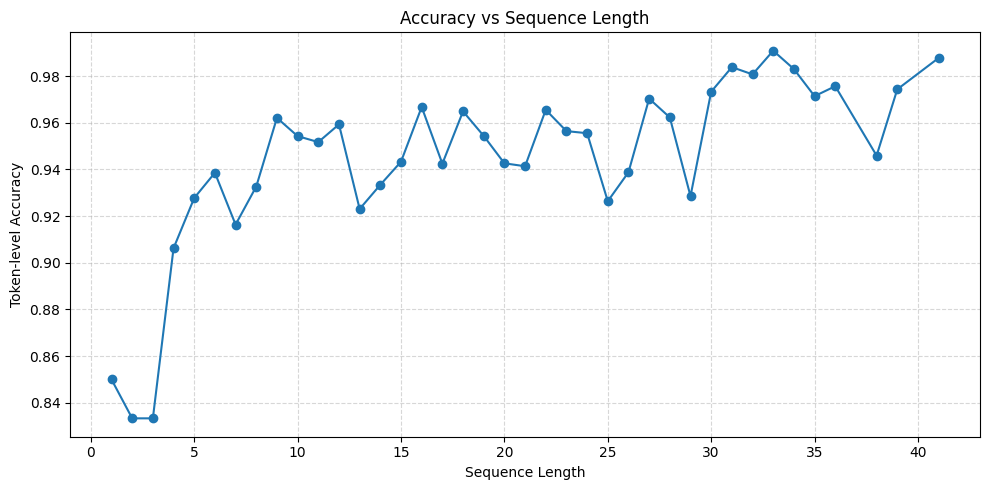

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

true_tags_flat = []
pred_tags_flat = []

length_bins = defaultdict(list)

for i in range(len(btc["validation"])):
    tokens = btc["validation"][i]["tokens"]
    length = len(tokens)
    true_ids = labels[i]
    pred_ids = preds[i]
    for t_id, p_id in zip(true_ids, pred_ids):
        if t_id != -100:
            correct = int(t_id == p_id)
            length_bins[length].append(correct)
lengths = sorted(length_bins.keys())
accuracies = [np.mean(length_bins[l]) for l in lengths]
plt.figure(figsize=(10, 5))
plt.plot(lengths, accuracies, marker="o")
plt.xlabel("Sequence Length")
plt.ylabel("Token-level Accuracy")
plt.title("Accuracy vs Sequence Length")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
